## Biblioteki

In [ ]:
%pip install numpy matplotlib deap pandas tqdm

In [2]:
from deap import tools
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import itertools
import math
import random
import warnings

# Graph Crossing Optimization


## Problem

The input is a graph, given as a list of vertices and edges.\
The output should be a drawing of the graph that minimizes the number of edge crossings.


## Proposed Algorithm


### Phenotype

All graph vertices are placed along the X-axis in a certain order.\
Edges between them are drawn as ellipses above or below the axis.

Example:


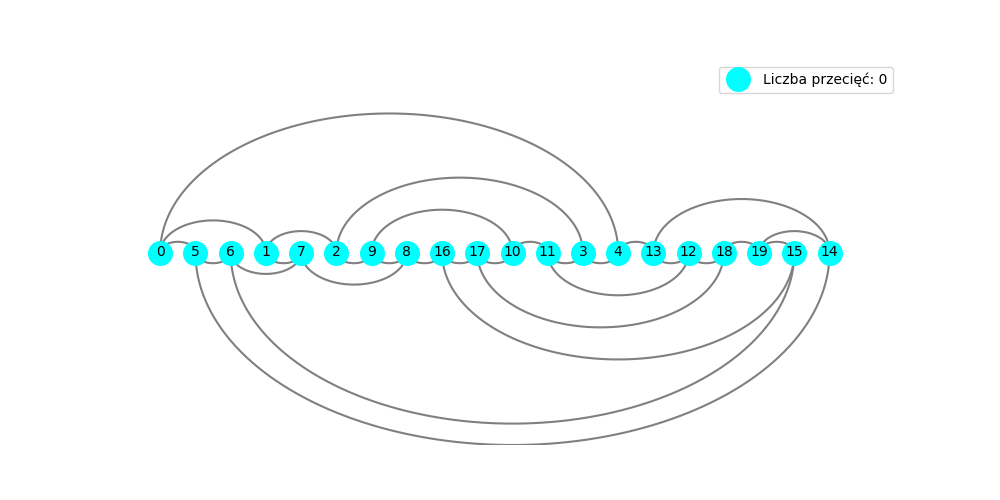


In [ ]:
# visualization function
def visualize_krzywe(n_verts, edges, solution):
    '''
    n_verts - number of graph vertices
    edges - list of graph edges
    solution - result of the evolutionary algorithm
    '''

    order, pages = solution
    rev_order = np.zeros(n_verts, dtype=int)

    _, ax = plt.subplots(figsize=(10, 5))
    for (i, vert) in enumerate(order):
        rev_order[vert] = i
        ax.plot(i, 0, 'o', markersize=17, color='cyan', zorder=2)
        ax.text(i, 0, f'{vert+1}', fontsize=10, ha='center', va='center', zorder=3)

    max_radius = 0
    total_crossings = 0

    other_edges = []
    for i, e in enumerate(edges):
        x1 = rev_order[e[0]]
        x2 = rev_order[e[1]]
        mid_x = (x1 + x2) / 2
        radius = abs(x2 - x1) / 2

        theta = np.linspace(0, np.pi, 100)
        max_radius = max(max_radius, radius)
        arc_x = mid_x + radius * np.cos(theta)
        arc_y = radius * np.sin(theta)

        # check intersection with previously drawn arcs
        for other_i, (other_mid, other_r) in enumerate(other_edges):
            if(pages[i] != pages[other_i]):
                continue

            if abs(mid_x - other_mid) < 0.1:
                continue

            x = (mid_x**2 - other_mid**2 - radius**2 + other_r**2) / (2*(mid_x - other_mid))
            y = radius**2 - (x - mid_x)**2
            if y <= 0:
                continue

            total_crossings += 1
            plt.plot(x, pages[i]*np.sqrt(y), 'o', markersize=5, color='red', zorder=5)

        other_edges.append((mid_x, radius))
        plt.plot(arc_x, pages[i]*arc_y, color='gray', zorder=1)

    plt.xlim(-1, n_verts+1)
    plt.ylim(-max_radius, max_radius)

    plt.legend([f'Number of crossings: {total_crossings}'])
    plt.axis('off')
    plt.show()


### Genotype

An individual consists of a permutation of the graph's vertices and an assignment of sides (top or bottom) for each edge.


### Population Initialization

The initial population is generated using the DFS algorithm. To diversify the population, a random starting point is chosen, and the order of edge selection is randomized. Edge drawing sides are also assigned randomly.


In [ ]:
def dfs_ordering(vertices, edges):
    """
    Vertex ordering obtained using the DFS algorithm.

    Args:
        vertices (list): List of graph vertices.
        edges (list): List of edges in the form (u, v).

    Returns:
        list: Vertex ordering.
    """
    visited = {v: False for v in vertices}
    order = []

    vertices_shuffled = random.sample(vertices, len(vertices))
    edges_shuffled = random.sample(edges, len(edges))

    def dfs(v):
        visited[v] = True
        for u, w in edges_shuffled:
            if u == v and not visited[w]:
                dfs(w)
        order.append(v)

    for v in vertices_shuffled:
        if not visited[v]:
            dfs(v)

    return order[::-1]

def dfs_individual(vertices, edges):
    """
    Generates an individual for the evolutionary algorithm. Permutation + edge sides
    """
    return dfs_ordering(vertices, edges), [((u, v), random.randint(0, 1)) for u, v in edges]


### Fitness Function

As fitness, we use the number of crossings between all edges.\
Edges are grouped by side, and for each pair of edges in the group, the following condition is checked:

$ \text{p}_1 < \text{p}_2 < \text{k}_1 < \text{k}_2 $

where:
 - p - coordinate of the starting vertex
 - k - coordinate of the ending vertex

If this condition is satisfied, the edges intersect. The total number of such crossings is then summed.


In [ ]:
# Edge Recombination Crossover
def edge_recombination(parent1, parent2):
    """
    Edge Recombination Crossover for generating offspring from two parents.

    Args:
        parent1 (list): First parent, a permutation of vertices.
        parent2 (list): Second parent, a permutation of vertices.

    Returns:
        list: Child, a permutation of vertices.
    """
    edges = {v: set() for v in parent1}
    size = len(parent1)

    # Build edge adjacency table from both parents
    for p in [parent1, parent2]:
        for i in range(size):
            edges[p[i]].add(p[(i - 1) % size])
            edges[p[i]].add(p[(i + 1) % size])

    current = parent1[0]
    child = [current]

    while len(child) < size:
        # Remove current vertex from all neighbor sets
        for neighbor in edges.values():
            neighbor.discard(current)

        # Choose next vertex with the fewest neighbors
        if edges[current]:
            current = min(edges[current], key=lambda x: len(edges[x]))
        else:
            # If no neighbors left, pick a random unused vertex
            remaining = set(parent1) - set(child)
            current = random.choice(list(remaining))

        child.append(current)

    return child


In [6]:
def count_edge_crossings(vertices, edges_page):
    position = {v: i for i, v in enumerate(vertices)}
    crossings = 0

    edges_top = [edge for edge, page in edges_page if page == 0]
    edges_bottom = [edge for edge, page in edges_page if page == 1]

    def count_crossings_on_page(edges):
        count = 0
        for i in range(len(edges)):
            for j in range(i + 1, len(edges)):
                u1, v1 = edges[i]
                u2, v2 = edges[j]

                u1_pos, v1_pos = position[u1], position[v1]
                u2_pos, v2_pos = position[u2], position[v2]

                if u1_pos > v1_pos:
                    u1_pos, v1_pos = v1_pos, u1_pos
                if u2_pos > v2_pos:
                    u2_pos, v2_pos = v2_pos, u2_pos

                if (u1_pos < u2_pos < v1_pos < v2_pos) or (u2_pos < u1_pos < v2_pos < v1_pos):
                    count += 1
        return count

    crossings += count_crossings_on_page(edges_top)
    crossings += count_crossings_on_page(edges_bottom)

    return crossings


### Recombination

The crossover of vertex permutations is performed using the PMX (Partially Matched Crossover) algorithm, which ensures the validity of the permutation. Additionally, the edge side assignments are mixed uniformly using the assignments from the parents.


In [ ]:
def edge_recombination(parent1, parent2):
    # Create edge map for both parents
    edges = {v: set() for v in parent1}
    size = len(parent1)

    for parent in [parent1, parent2]:
        for i in range(size):
            edges[parent[i]].add(parent[(i - 1) % size])  # previous vertex
            edges[parent[i]].add(parent[(i + 1) % size])  # next vertex

    # Start from the first vertex of parent1
    current = parent1[0]
    child = [current]

    while len(child) < size:
        # Remove current vertex from neighbors' sets
        for neighbors in edges.values():
            neighbors.discard(current)

        # Choose neighbor with the fewest edges
        if edges[current]:
            current = min(edges[current], key=lambda x: len(edges[x]))
        else:
            # If no neighbors left, choose a random remaining vertex
            remaining = set(parent1) - set(child)
            current = random.choice(list(remaining))

        # Append chosen vertex to child
        child.append(current)

    return child


### Mutation

Mutation of the vertex permutation involves swapping the positions of two or more random vertices, while mutation of the edge page assignments flips the side (top/bottom) with a given probability.


In [ ]:
def mutate_harder(individual, mutation_rate=0.1):
    vertex_order, edges_page = individual

    # Mutation of the vertex permutation
    for i in range(len(vertex_order)):
        if random.random() < mutation_rate:
            j = np.random.randint(0, len(vertex_order))
            vertex_order[i], vertex_order[j] = vertex_order[j], vertex_order[i]

    # Mutation of the edge page assignments
    for k in range(len(edges_page)):
        if random.random() < mutation_rate:
            edge, page = edges_page[k]
            edges_page[k] = (edge, 1 - page)  # Flip the page

    return vertex_order, edges_page


### Selection

50% of individuals with the best fitness values remain in the pool, and then random individuals from the rest are crossed over until the desired population size is reached.


### Stopping Condition

The algorithm runs for a specified number of generations (250) or until a graph with no crossings is found.


### Final Evolutionary Algorithm


In [ ]:
def evolutionary_algorithm2(vertices, edges, stats=None, population_size=125, generations=300, mutation_rate=0.05, quiet=False):
    evaluation_count = 0

    # Population initialization
    population = [dfs_individual(vertices, edges) for _ in range(population_size)]

    for generation in range(generations):
        # Population evaluation
        fitness = []
        for ind in population:
            fitness_value = count_edge_crossings(ind[0], ind[1])
            fitness.append(fitness_value)
            evaluation_count += 1

        sorted_population = sorted(zip(population, fitness), key=lambda x: x[1])
        population = [ind for ind, _ in sorted_population]

        # Print result for current generation
        best_fitness = sorted_population[0][1]
        worst_fitness = sorted_population[-1][1]
        avg_fitness = sum(fitness) / len(fitness)

        if stats is not None:
            stats.append((best_fitness, avg_fitness, worst_fitness))

        if not quiet:
            print(f"Generation {generation + 1}: min = {best_fitness}, avg = {avg_fitness}, max = {worst_fitness}, Evaluations = {evaluation_count}")

        if abs(best_fitness) < 0.1:
            break

        # Parent selection
        parents = population[:population_size // 2]

        # Creating new population
        new_population = parents[:]
        while len(new_population) < population_size:
            parent1, parent2 = random.sample(parents, 2)
            child1 = edge_recombination(parent1[0], parent2[0])  # Edge Recombination
            child1_edges = [(edge, random.randint(0, 1)) for edge, _ in parent1[1]]
            new_population.append(mutate_harder((child1, child1_edges), mutation_rate))

        population = new_population

    # Return the best solution
    best_solution = min(population, key=lambda ind: count_edge_crossings(ind[0], ind[1]))
    return best_solution, best_fitness, evaluation_count


## Algorithm Performance Statistics


### Test Graphs

The following graphs were used for calculating statistics

[Dodecahedron](https://en.wikipedia.org/wiki/Planar_graph) (0 przecięć)              |  [K 4,7](https://en.wikipedia.org/wiki/Tur%C3%A1n%27s_brick_factory_problem) (18 przecięć)
:-------------------------:|:-------------------------:
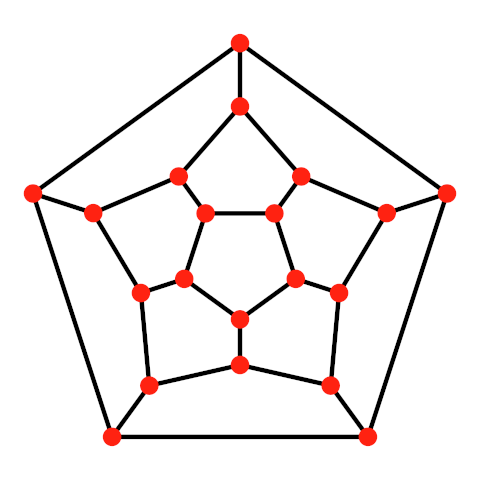  |  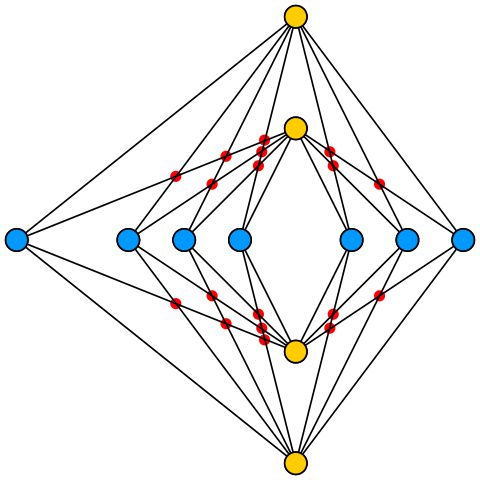

In [10]:
# Dodecahedron
graf1 = ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [[6, 15], [17, 10], [2, 3], [11, 12], [19, 14], [13, 14], [0, 1], [6, 7], [0, 5], [8, 7], [18, 12], [17, 18], [10, 11], [8, 16], [9, 2], [3, 4], [1, 7], [9, 10], [1, 2], [4, 13], [5, 14], [8, 9], [16, 17], [19, 15], [0, 4], [16, 15], [5, 6], [18, 19], [12, 13], [11, 3]])

# K 4,7
graf2 = ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [[8, 2], [1, 4], [9, 3], [3, 7], [0, 10], [2, 6], [3, 6], [0, 5], [8, 3], [1, 5], [0, 7], [1, 10], [2, 7], [9, 2], [0, 8], [0, 9], [3, 4], [1, 9], [0, 6], [1, 7], [2, 10], [2, 5], [10, 3], [0, 4], [2, 4], [8, 1], [3, 5], [1, 6]])

### Przykład działania

In [ ]:
def test_algo(graph):
    vertices, edges = graph

    # Run the evolutionary algorithm
    (best_vertices, best_edges_page), fit, evals = evolutionary_algorithm2(vertices, edges, quiet=True)
    edges2 = [(u-1, v-1) for (u, v) in edges]
    verts = [v-1 for v in best_vertices]
    pages_diff = [page*2-1 for _, page in best_edges_page]

    print(f"Best vertex ordering: {best_vertices}")
    print(f"Best edge page assignment: {best_edges_page}")
    print(f"Number of crossings: {fit}")
    print(f"Number of evaluations: {evals}")
    visualize_krzywe(len(verts), edges2, (verts, pages_diff))

In [ ]:
test_algo(graf1)

In [ ]:
test_algo(graf2)

### Efficiency / Performance


In [ ]:
def stats(graf, algo, actual_minimum=None):
    warnings.filterwarnings("ignore")
    vertices, edges = graf

    results = []
    for i in tqdm(range(100)):
        # Run the evolutionary algorithm
        _, fitness, evals = algo(vertices, edges, quiet=True)
        results.append([fitness, evals])

    df = pd.DataFrame(results, columns=['Crossings', 'Fitness evaluations'])
    crossings = df['Crossings']
    print(f'success_rate: { crossings.value_counts().get(actual_minimum, 0) / df.shape[0] * 100 } %')
    print()

    display(df.describe())
    print()


In [ ]:
print('Graph 1 - 0 crossings \n')
stats(graf1, evolutionary_algorithm2, actual_minimum=0)


In [ ]:
print('Graf 2 - 18 crossings \n')
stats(graf2, evolutionary_algorithm2, actual_minimum=18)

### Average fitness depending on the generation

In [ ]:
def graph_fitness(gname, graph):
    for i in tqdm(range(25)):
        stats = []
        _, fitness, evals = evolutionary_algorithm2(graph[0], graph[1], quiet=True, stats=stats)
        plt.plot(np.arange(len(stats)), np.swapaxes(np.array(stats), 0, 1)[1])

    plt.title('Average number of crossings depending on generation - ' + gname)
    plt.xlabel('Generation')
    plt.ylabel('Average fitness value in population')
    plt.show()


In [ ]:
graph_fitness('graf 1 (0 crossings)', graf1)

In [ ]:
graph_fitness('graf 2 (18 crossings)', graf2)